In [39]:
import numpy as np
import pylab
import itertools
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error

In [40]:
def twospirals(n_points, noise=.0, square=False, sine=False):
    '''
     Returns n_points for the two spirals dataset.
    '''
    n_points = int(n_points/2)
    n = np.sqrt( np.random.rand(n_points,1) ) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    d1 = (d1x, d1y)
    negd1 = (-d1x, -d1y)

    if sine: 
        sinx1, sinx2 = np.sin(d1x), np.sin(d1y)
        d1 += (sinx1, sinx2)
        negd1 += (-sinx1, -sinx2)
    if square:
        sqx1, sqx2 = d1x*d1x, d1y*d1y
        d1 += (sqx1, sqx2)
        negd1 += (-sqx1, -sqx2)

    x1 = np.hstack(d1)
    x2 = np.hstack(negd1)
    x = np.vstack( (x1, x2) )
    y = np.hstack( ( np.zeros(n_points), np.ones(n_points) ) )
    return (x, y.astype(int))

In [41]:
# X_train, y_train = twospirals(n_points=200)
# X_test, y_test = twospirals(n_points=200)

# plt.title('training and testing set')
# plt.plot(X_train[y_train==0,0], X_train[y_train==0,1], '.', label='training class 1')
# plt.plot(X_train[y_train==1,0], X_train[y_train==1,1], '.', label='training class 2')
# plt.plot(X_test[y_test==0,0], X_test[y_test==0,1], '.', label='testing class 1')
# plt.plot(X_test[y_test==1,0], X_test[y_test==1,1], '.', label='testing class 2')
# plt.legend()
# plt.show()

In [42]:
def fitness_func(population):
    fitness_list = np.zeros(N)
    mse_list = np.zeros(N)
    for member in range(len(population)):
        # TODO: add check for non zeros
        member_layer_sizes = tuple(int(l) for l in population[member])
        
        # fitness = test accuracy as %
        clf = MLPClassifier(max_iter=3, hidden_layer_sizes=member_layer_sizes, solver='lbfgs', random_state=0)
        clf.fit(X_train, y_train)
        fitness = clf.score(X_test, y_test) * 100

        # mse for test set just for plotting
        mse_list[member] = mean_squared_error(y_test, clf.predict(X_test))
        # sort population in descending fitness
        fitness_list[member] = fitness
        fitness_indices = (-fitness_list).argsort()
        sorted_pop = population[fitness_indices]

    mse = np.sum(mse_list)/N
    avg_fitness = np.sum(fitness_list)/N
    max_fitness = max(fitness_list)
    fitness_list = fitness_list[fitness_indices]
    return sorted_pop, fitness_list, avg_fitness, max_fitness, mse

In [43]:
def roulette_wheel_selection(sorted_pop, fitness_list):
    '''
    sorted_pop = population members sorted in descending (best to worst)
    fitness_list = corresponding fitness list for sorted_pop
    '''
    intermediate_pop = np.random.randint(low=1, high=neuron_range, size=(N,dim))
    total_fit = np.sum(fitness_list)
    select_from = np.arange(N)

    if total_fit == 0:
        total_fit = 1
        relative_fitness = fitness_list + 1/N
    else:
        relative_fitness = fitness_list / total_fit

    mating_population = np.random.choice(select_from, size=N, p=relative_fitness)
    for member in range(len(mating_population)):
        intermediate_pop[member] = sorted_pop[mating_population[member]]
    return intermediate_pop

In [44]:
def crossover(parent1, parent2):
    c_point = np.random.randint(0, dim) # random rossover point
    child1 = np.random.randint(low=1, high=neuron_range, size=dim)
    child2 = np.random.randint(low=1, high=neuron_range, size=dim)

    child1[:c_point] = parent1[:c_point]
    child1[c_point:] = parent2[c_point:]
    
    child2[c_point:] = parent1[c_point:]
    child2[:c_point] = parent2[:c_point]
    return child1, child2

In [45]:
def mutate(population):
    for member in population:
        for chromosome in range(dim):
            if np.random.rand()<p_m:
                # change a chromosome to random int (between 1-8)
                member[chromosome] = np.random.randint(1, dim)
    return population

In [46]:
def new_generation(intermediate_pop):
    new_pop = np.ones((N,dim))
    parent_list = np.arange(N)
    pairings = np.random.choice(parent_list, (2,int(N/2)), replace =False)
    #print(pairings)
    for x in range(np.int(N/2)):
        parent1 = pairings[0][x]
        parent2 = pairings[1][x]
        new_pop[x], new_pop[(N-1)-x] = crossover(intermediate_pop[parent1], intermediate_pop[parent2])
    mutate(new_pop)
    return new_pop

<br><br>
# TESTS

In [47]:
X_train, y_train = twospirals(n_points=200)
X_test, y_test = twospirals(n_points=200)

dim = 4             # number of layers i.e. dimension of the search space (D)
neuron_range = 9    # neurons on each hidden layer can range from 1 to 9
    
N = 10              # Size of the population of solutions
T = 100             # Number of generations
p_c = 0.7           # Crossover probability
p_m = 0.05          # Mutation probbability

init_pop = np.random.randint(low=1, high=neuron_range, size=(N,dim))
print(f'init_pop.shape {init_pop.shape}\ninit_pop = \n{init_pop[:10]}\n...')

init_pop.shape (10, 4)
init_pop = 
[[4 4 8 3]
 [6 7 1 5]
 [8 2 4 6]
 [8 2 8 3]
 [7 7 3 1]
 [6 5 8 3]
 [2 5 3 4]
 [1 1 8 5]
 [8 4 5 6]
 [3 8 6 7]]
...


In [48]:
generation_avg_fitness = []
generation_max_fitness = []
generation_mse = []
cur_gen = init_pop
for t in range(T):
    sorted_pop, fitness_list, avg_fitness, max_fitness, mse = fitness_func(cur_gen)
    generation_mse.append(mse)
    generation_avg_fitness.append(avg_fitness)
    generation_max_fitness.append(max_fitness)
    intermediate_pop = roulette_wheel_selection(sorted_pop, fitness_list)
    new_gen = new_generation(intermediate_pop)
    cur_gen = new_gen
    # if max_fitness > 95:
    #     print(f"Found perfect solution at generation {t}")
    #     break # you may like to remove the break to see how the avarege fitness approach the maximal fitness

max fitness achieved 67.0 @ gen 396


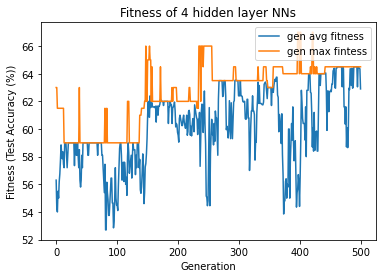

In [49]:
pylab.xlabel('Generation')
pylab.ylabel('Fitness (Test Accuracy (%))')
pylab.title(f'Fitness of {dim} hidden layer NNs')
pylab.plot(generation_avg_fitness, label='gen avg fitness');
pylab.plot(generation_max_fitness, label='gen max fintess');
pylab.legend(loc='upper right')

max_fitness = max(generation_max_fitness)
print(f'max fitness achieved {max_fitness} @ gen {generation_max_fitness.index(max_fitness)}')

min mse achieved 0.3550 @ gen 461 w/ pop 10


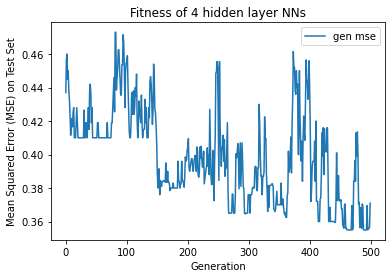

In [50]:
pylab.xlabel('Generation')
pylab.ylabel('Mean Squared Error (MSE) on Test Set')
pylab.title(f'Fitness of {dim} hidden layer NNs')
pylab.plot(generation_mse, label='gen mse');
pylab.legend(loc='upper right')

min_mse = min(generation_mse)
print(f'min mse achieved {min_mse:.4f} @ gen {generation_mse.index(min_mse)} w/ pop {N}')